# Changing the dimensionality of glove word embeddings

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import torch as tt
from torch import nn
import matplotlib.pyplot as plt

In [2]:
GLOVE_FILE = '../data/glove.6B/glove.6B.50d.txt'

## Load the embeddings

In [3]:
# most of the code in the cell comes from Stackoverflow

# Get number of vectors and hidden dim
with open(GLOVE_FILE, 'r') as f:
    for i, line in tqdm(enumerate(f)):
        pass
n_vec = i + 1
embedding_size = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, embedding_size), dtype=np.float32)
embeds = {}

with open(GLOVE_FILE, 'r') as f:
    for i, line in tqdm(enumerate(f)):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)
        embeds[line.split(' ')[0]] = i

## See how MSELoss cahnges with different target embedding size

In [4]:
target_sizes = [3, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]  # different target embedding sizes
batch_size = 100000
learning_rate=1e-3

In [5]:
class SimpleAutoencoder(nn.Module):
    """Simple One layer Autoencoder"""
    def __init__(self, target_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Linear(embedding_size, target_size)
        self.decoder = nn.Linear(target_size, embedding_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class MultiLayerAutoencoder(nn.Module):
    """A Three layer Autoencoder. For Experimental purposes"""
    def __init__(self, target_size):
        super(MultiLayerAutoencoder, self).__init__()
        midway = int((embedding_size/target_size)**0.5)
        self.encoder = nn.Sequential(
            nn.Linear(embedding_size, midway),
            nn.Tanh(),
            nn.Linear(midway, target_size))
        self.decoder = nn.Sequential(
            nn.Linear(target_size, midway),
            nn.Tanh(),
            nn.Linear(midway, embedding_size))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
def train_model(target_size, train_data, autoencoder, patience=10, margin=1e-4, model=None, evaluate=False):
    """
    Train an auntoencoder for specified target size. Return the model and the loss
    :param target_size: target embedding size
    :param train_data:  training data
    :param patience:    the training will stop when the loss will not improve more than by margin in patience epochs
    :param margin:      the training will stop when the loss will not improve more than by margin in patience epochs
    :reaturn:           autoencoder, lost for last epoch
    """
    if model is None:
        model = autoencoder(target_size)
    if evaluate:
        model.eval()
    else:
        model.train()
    model.cuda()
    criterion = nn.MSELoss()
    optimizer = tt.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    best_loss = -1
    patience_left = patience
    epoch = -1
    bar = tqdm()
    while patience_left > 0:
        np.random.shuffle(train_data)
        epoch += 1
        total_loss = 0
        id = 0
        while id < len(vecs):
            if id + batch_size <=len(train_data):
                batch = tt.tensor(train_data[id:id+batch_size]).cuda()
            else:
                batch = tt.tensor(train_data[id:]).cuda()
            id += batch_size
            output = model(batch)
            loss = criterion(output, batch)
            total_loss += loss.item()
            if not evaluate:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        total_loss *= batch_size/len(train_data)  # to get the mean
        if evaluate:
            break
        if best_loss == -1 or best_loss > total_loss + margin:
            best_loss = total_loss
            patience_left = patience
        else:
            patience_left -= 1
        bar.set_description("Size: %d, Epochs: %d, Loss: %f" %(target_size, epoch, total_loss))
        bar.update(1)
    return total_loss, model

### See how loss changes depending on the autoencoder used and target embedding size

### Simple Autoencoder

In [13]:
losses = []
models = {}
train_data = vecs.copy()  # so that the vectors can be shuffled
for target_size in target_sizes:
    loss, model = train_model(target_size, train_data, SimpleAutoencoder)
    losses.append(loss)
    models[target_size] = model
    tt.save(model.state_dict(), "../data/glove.6B/" + str(target_size) + ".model")

In [14]:
for target_size in target_sizes:
    model = SimpleAutoencoder(target_size)
    model.load_state_dict(tt.load("../data/glove.6B/" + str(target_size) + ".model"))
    loss, model = train_model(target_size, train_data, SimpleAutoencoder, 1, 1, model, True)
    print(target_size, loss)

3 0.32650187611579895



5 0.3017766624689102


8 0.26981955021619797


10 0.24994488805532455


12 0.2307213880121708


15 0.20354678481817245






20 0.16081150993704796


25 0.12133792415261269


30 0.4688830152153969


35 0.04856688156723976





40 0.01712902681902051


45 0.0012067427160218358


50 0.0010218825191259384


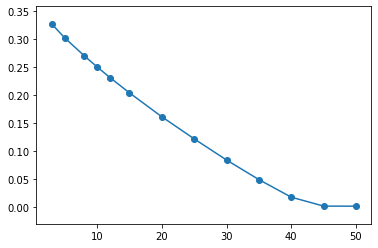

In [23]:
# x axis is embedding size, y axis is mse loss
plt.scatter(target_sizes,losses)
plt.plot(target_sizes, losses)
plt.show()

### Multilayer Autoencoder (TODO: this one performs badly, fix it)

In [24]:
losses_m = []
models_m = {}
train_data = vecs.copy()  # so that the vectors can be shuffled
for target_size in target_sizes:
    loss, model = train_model(target_size, train_data, MultiLayerAutoencoder)
    losses_m.append(loss)
    models_m[target_size] = model

KeyboardInterrupt: 

In [ ]:
plt.scatter(target_sizes,losses_m)
plt.plot(target_sizes, losses_m)
plt.show()

## Check the model output (e.g. how well are embeddings actually reproduced)

In [ ]:
model = models[10].cpu()  # select a particular target size to look at

In [ ]:
for vec in vecs:
    prediction = model(tt.tensor(vec)).detach().numpy()
    difference = np.sum((vec-prediction)**2)
    mse = np.mean((vec-prediction)**2)
    print(np.sum(vec**2), np.sum(prediction ** 2), difference, mse)
    print(vec[:10])
    print(prediction[:10])

## Save the embeddings

In [17]:
# most of the code in the cell is from Stackoverflow
target_size = 8
NEW_GLOVE_FILE = '../data/glove.6B/glove.6B.' + str(target_size) + 'd.txt'
embed_inverse = {embeds[string]:string for string in embeds.keys()}

with open(NEW_GLOVE_FILE, 'w') as file:
    for i in tqdm(range(len(vecs))):
        file.write(embed_inverse[i] + " ")
        new_embedding = models[target_size].encoder(tt.tensor(vecs[i]).cuda()).detach().cpu().numpy()
        file.write(" ".join(str(x) for x in new_embedding) + "\n")